# Feature Overview
To demonstrate the features of mlwhatif, we will use the running example from the paper.

![overview](paper_example_image.png)

Let us start by looking at the full pipeline source code.

In [1]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython
import os
from example_pipelines.healthcare import custom_monkeypatching
from mlwhatif.utils import get_project_root

DEMO_PY = os.path.join(str(get_project_root()), "demo", "feature_overview", "healthcare.py")

with open(DEMO_PY) as pipline_file:
    code = pipline_file.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

To now conduct our what-if analyses, we do not need to rewrite this pipeline file, we can use it directly as input for mlwhatif. Now, let us look at different analyses already implemented in mlwhatif.

## Data Corruption
Here, we test the robustness of our pipeline against different data quality errors.

In [2]:
from mlwhatif import PipelineAnalyzer
from mlwhatif.analysis._data_corruption import DataCorruption, CorruptionType
import warnings
warnings.filterwarnings('ignore')  # To keep the output readable


robustness = DataCorruption([('smokes', CorruptionType.CATEGORICAL_SHIFT),
                             ('notes', CorruptionType.BROKEN_CHARACTERS),
                             ('weight', CorruptionType.SCALING)],
                             corruption_percentages=[0.33, 0.66, 1.0])

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()

robustness_report = analysis_result.analysis_to_result_reports[robustness]

2022-10-14 10:38:07 INFO  Running instrumented original pipeline...
2022-10-14 10:38:07 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 10:38:07 INFO  ---RUNTIME: Importing and monkey-patching took 211.38381958007812 ms
2022-10-14 10:38:08 INFO  ---RUNTIME: Original pipeline execution took 1039.0691757202148 ms (excluding imports and monkey-patching)
2022-10-14 10:38:08 INFO  Starting execution of 1 what-if analyses...
2022-10-14 10:38:08 INFO  Start plan generation for analysis DataCorruption...
2022-10-14 10:38:08 INFO  ---RUNTIME: Plan generation took 0.1678466796875 ms
2022-10-14 10:38:08 INFO  Estimated runtime of original DAG is 1006.8912506103516ms
2022-10-14 10:38:08 INFO  Performing Multi-Query Optimization
2022-10-14 10:38:08 INFO  Estimated unoptimized what-if runtime is 9062.021255493164ms
2022-10-14 10:38:08 INFO  Estimated optimised what-if runtime is 1788.5229587554932ms
2022-10-14 10:38:08 INFO  Estima

Let us start by looking at the report generated by the analysis. In the first column, wee see the corruption that is being corrupted in the tested pipeline variant. In the second column, wee see the fraction of currupted values in the column. In the third column, wee see the utility score of that variant. In the first row, we see the score of the original pipeline.

Here, find that our pipeline is relatively robust against the tested data quality issues, as long as they appear in one column at a time. The lowest utility score we see is for high fractions of missing values in the `star_rating` column. This would be a candidate for data quality monitoring when deploying the pipeline in production.

In [3]:
robustness_report

column  corruption_percentage  accuracy_score_corrupt_test_only_L70
0    None                    NaN                              0.748017
1  smokes                   0.33                              0.748017
2  smokes                   0.66                              0.748017
3  smokes                   1.00                              0.748017
4   notes                   0.33                              0.748017
5   notes                   0.66                              0.748017
6   notes                   1.00                              0.748017
7  weight                   0.33                              0.573804
8  weight                   0.66                              0.421847
9  weight                   1.00                              0.251983

## Permutation Feature Importance
Next, we try looking at the importance of different features.

In [4]:
from mlwhatif.analysis._permutation_feature_importance import PermutationFeatureImportance

importance = PermutationFeatureImportance()

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(importance) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()

importance_report = analysis_result.analysis_to_result_reports[importance]

2022-10-14 10:38:10 INFO  Running instrumented original pipeline...
2022-10-14 10:38:10 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 10:38:10 INFO  ---RUNTIME: Importing and monkey-patching took 11.18612289428711 ms
2022-10-14 10:38:10 INFO  ---RUNTIME: Original pipeline execution took 946.7289447784424 ms (excluding imports and monkey-patching)
2022-10-14 10:38:10 INFO  Starting execution of 1 what-if analyses...
2022-10-14 10:38:10 INFO  Start plan generation for analysis PermutationFeatureImportance...
2022-10-14 10:38:10 INFO  ---RUNTIME: Plan generation took 0.26488304138183594 ms
2022-10-14 10:38:10 INFO  Estimated runtime of original DAG is 897.2609043121338ms
2022-10-14 10:38:10 INFO  Performing Multi-Query Optimization
2022-10-14 10:38:10 INFO  Estimated unoptimized what-if runtime is 2691.7827129364014ms
2022-10-14 10:38:11 INFO  Estimated optimised what-if runtime is 1094.2401885986328ms
2022-10-14 10:38

Now let us look at the report. We see that the model does not rely on any single feature too much, but that `total_votes` seems to be the most important single feature.

## A small peak under the hood
Internally, mlwhatif extracts a re-executable plan of the original pipeline and uses multi-query optimization to optimize the execution of what-if analyses. Let us take a look at what this looks like for a simple example.
We will try to keep the what-if analysis very simple for readability.

In [5]:
from IPython.core.display import Image
EXAMPLE_ORIGINAL_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "example-orig")
EXAMPLE_OPTIMIZED_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "example-optimised")

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()
analysis_result.save_original_dag_to_path(EXAMPLE_ORIGINAL_PLAN_PATH)
analysis_result.save_optimised_what_if_dags_to_path(EXAMPLE_OPTIMIZED_PLAN_PATH)

2022-10-14 10:38:12 INFO  Running instrumented original pipeline...
2022-10-14 10:38:12 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 10:38:12 INFO  ---RUNTIME: Importing and monkey-patching took 9.790897369384766 ms
2022-10-14 10:38:13 INFO  ---RUNTIME: Original pipeline execution took 1131.0710906982422 ms (excluding imports and monkey-patching)
2022-10-14 10:38:13 INFO  Starting execution of 1 what-if analyses...
2022-10-14 10:38:13 INFO  Start plan generation for analysis DataCorruption...
2022-10-14 10:38:13 INFO  ---RUNTIME: Plan generation took 0.24318695068359375 ms
2022-10-14 10:38:13 INFO  Estimated runtime of original DAG is 1094.3121910095215ms
2022-10-14 10:38:13 INFO  Performing Multi-Query Optimization
2022-10-14 10:38:13 INFO  Estimated unoptimized what-if runtime is 9848.809719085693ms
2022-10-14 10:38:13 INFO  Estimated optimised what-if runtime is 1727.7092933654785ms
2022-10-14 10:38:13 INFO  Est

The original DAG.

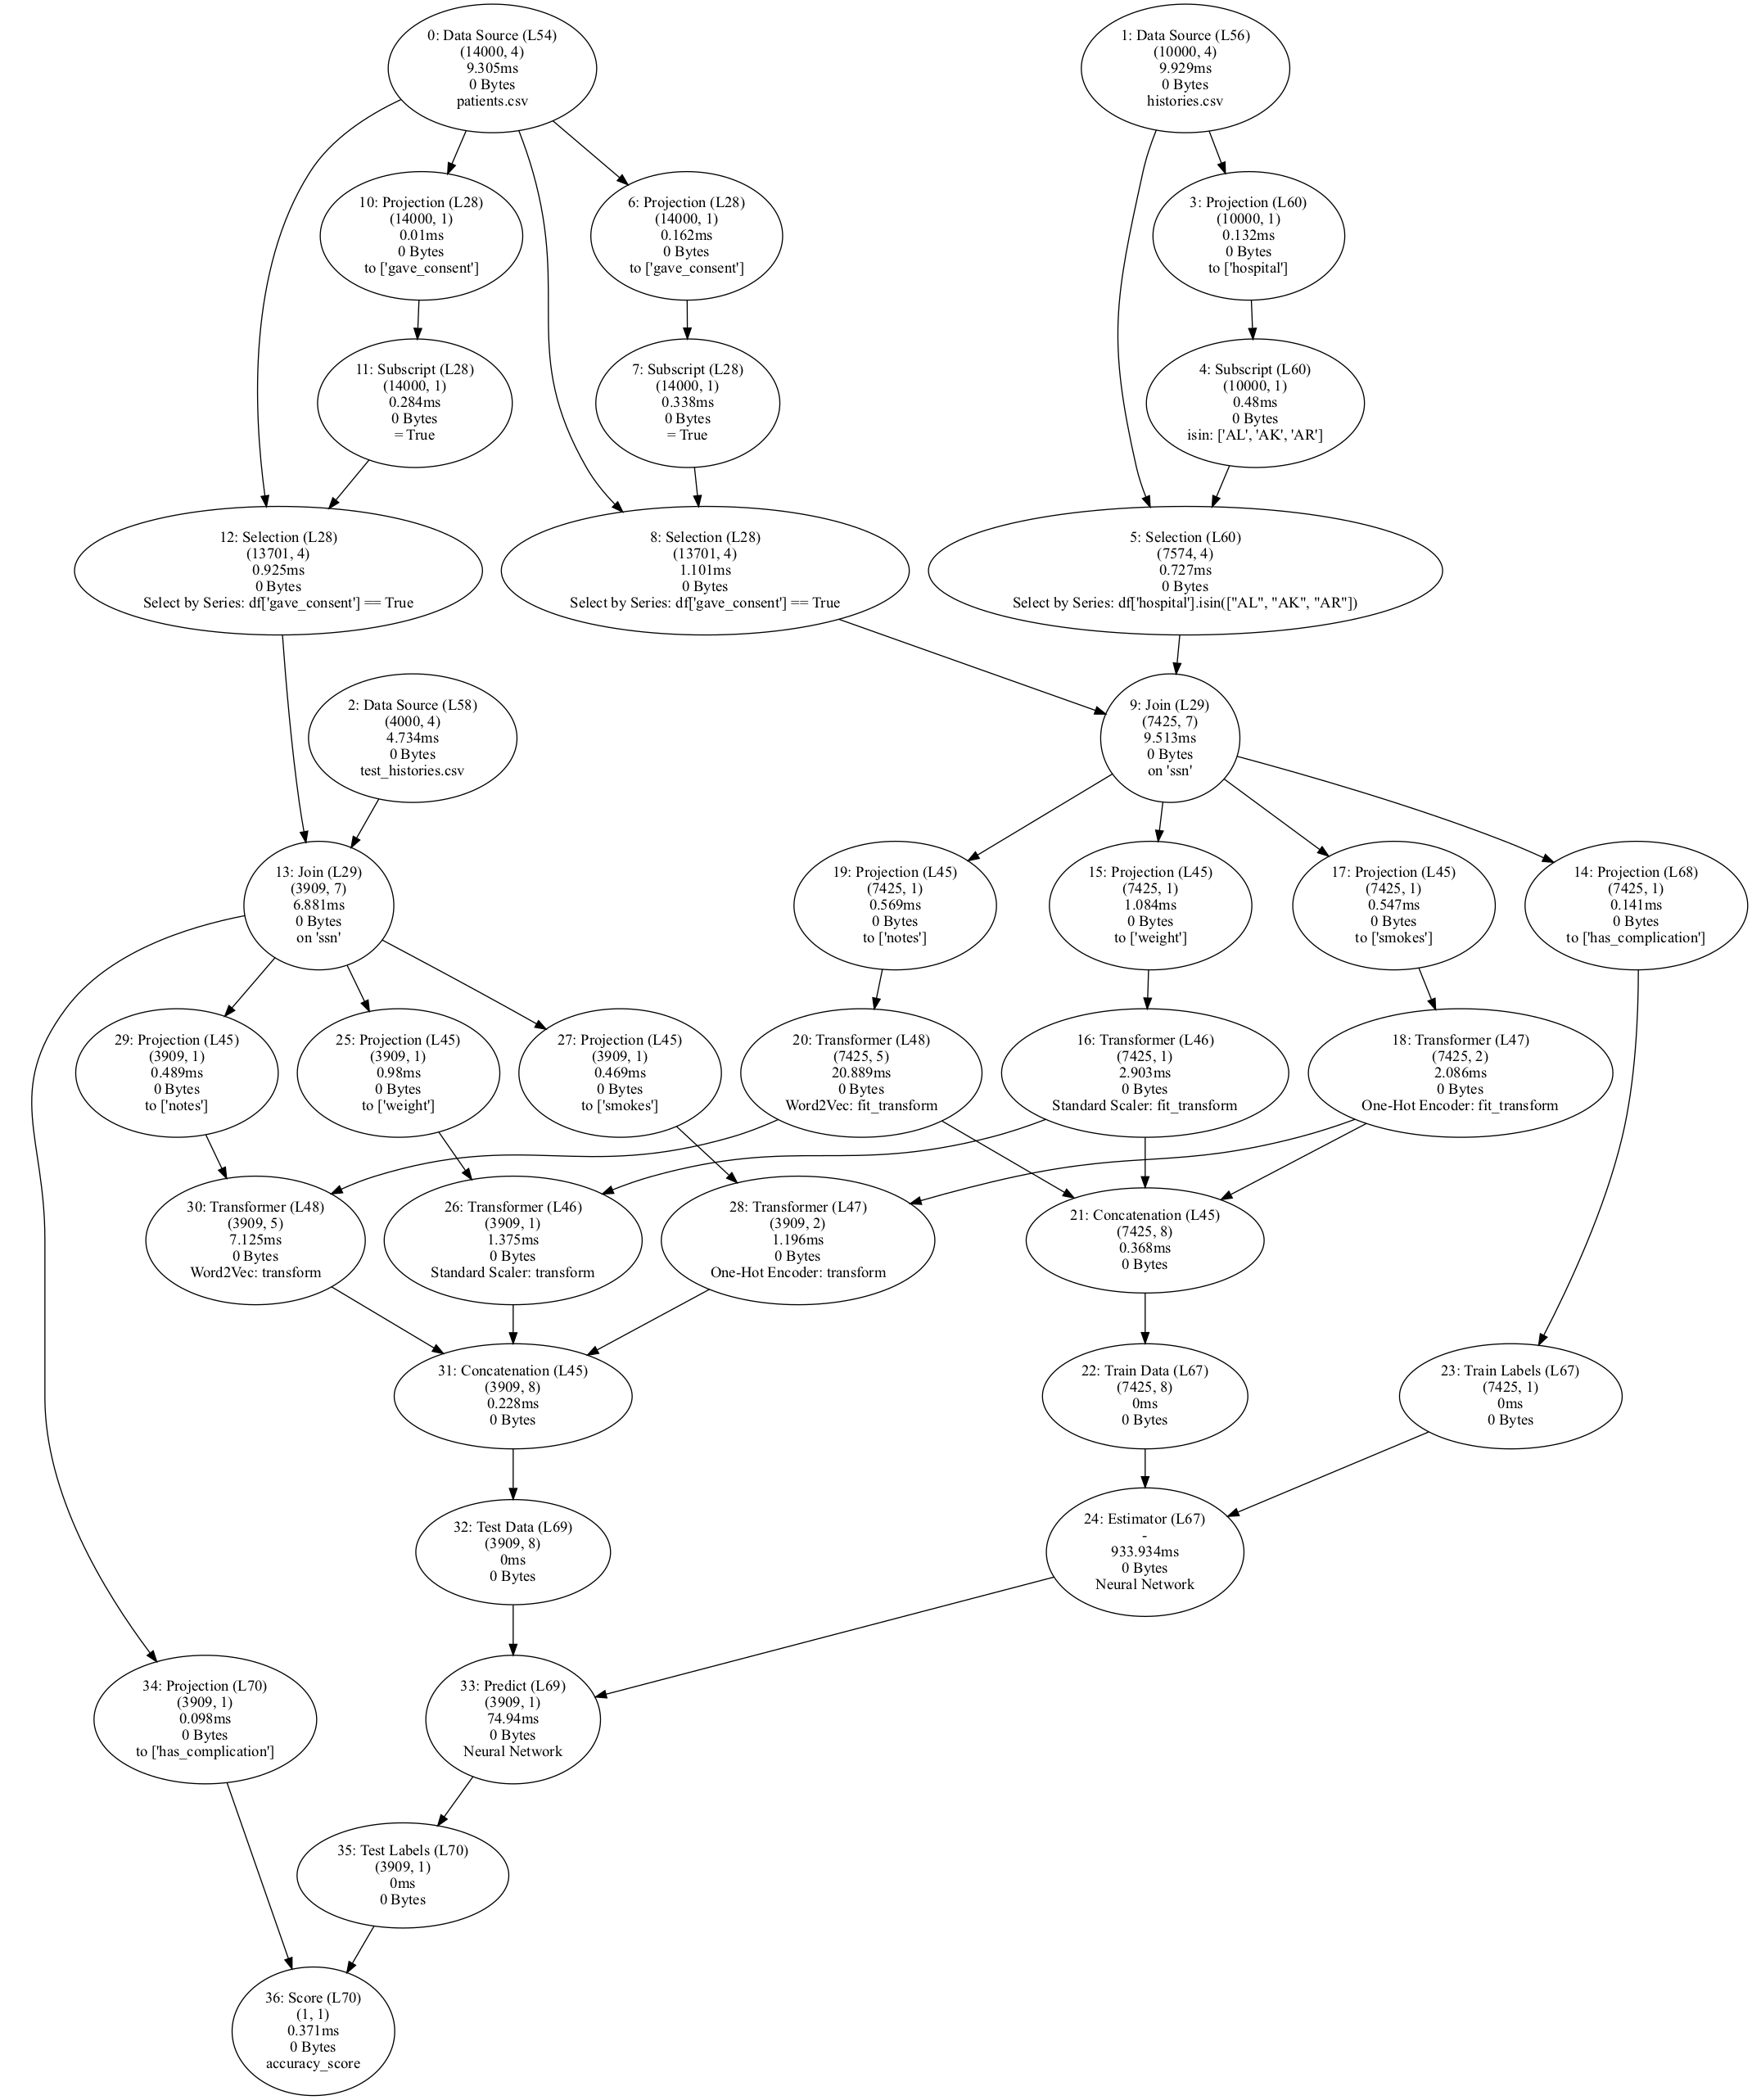

In [6]:
Image(filename=f"{EXAMPLE_ORIGINAL_PLAN_PATH}.png")

The optimised DAG. Note how similar it is to the original DAG thanks to multi-query optimisation.

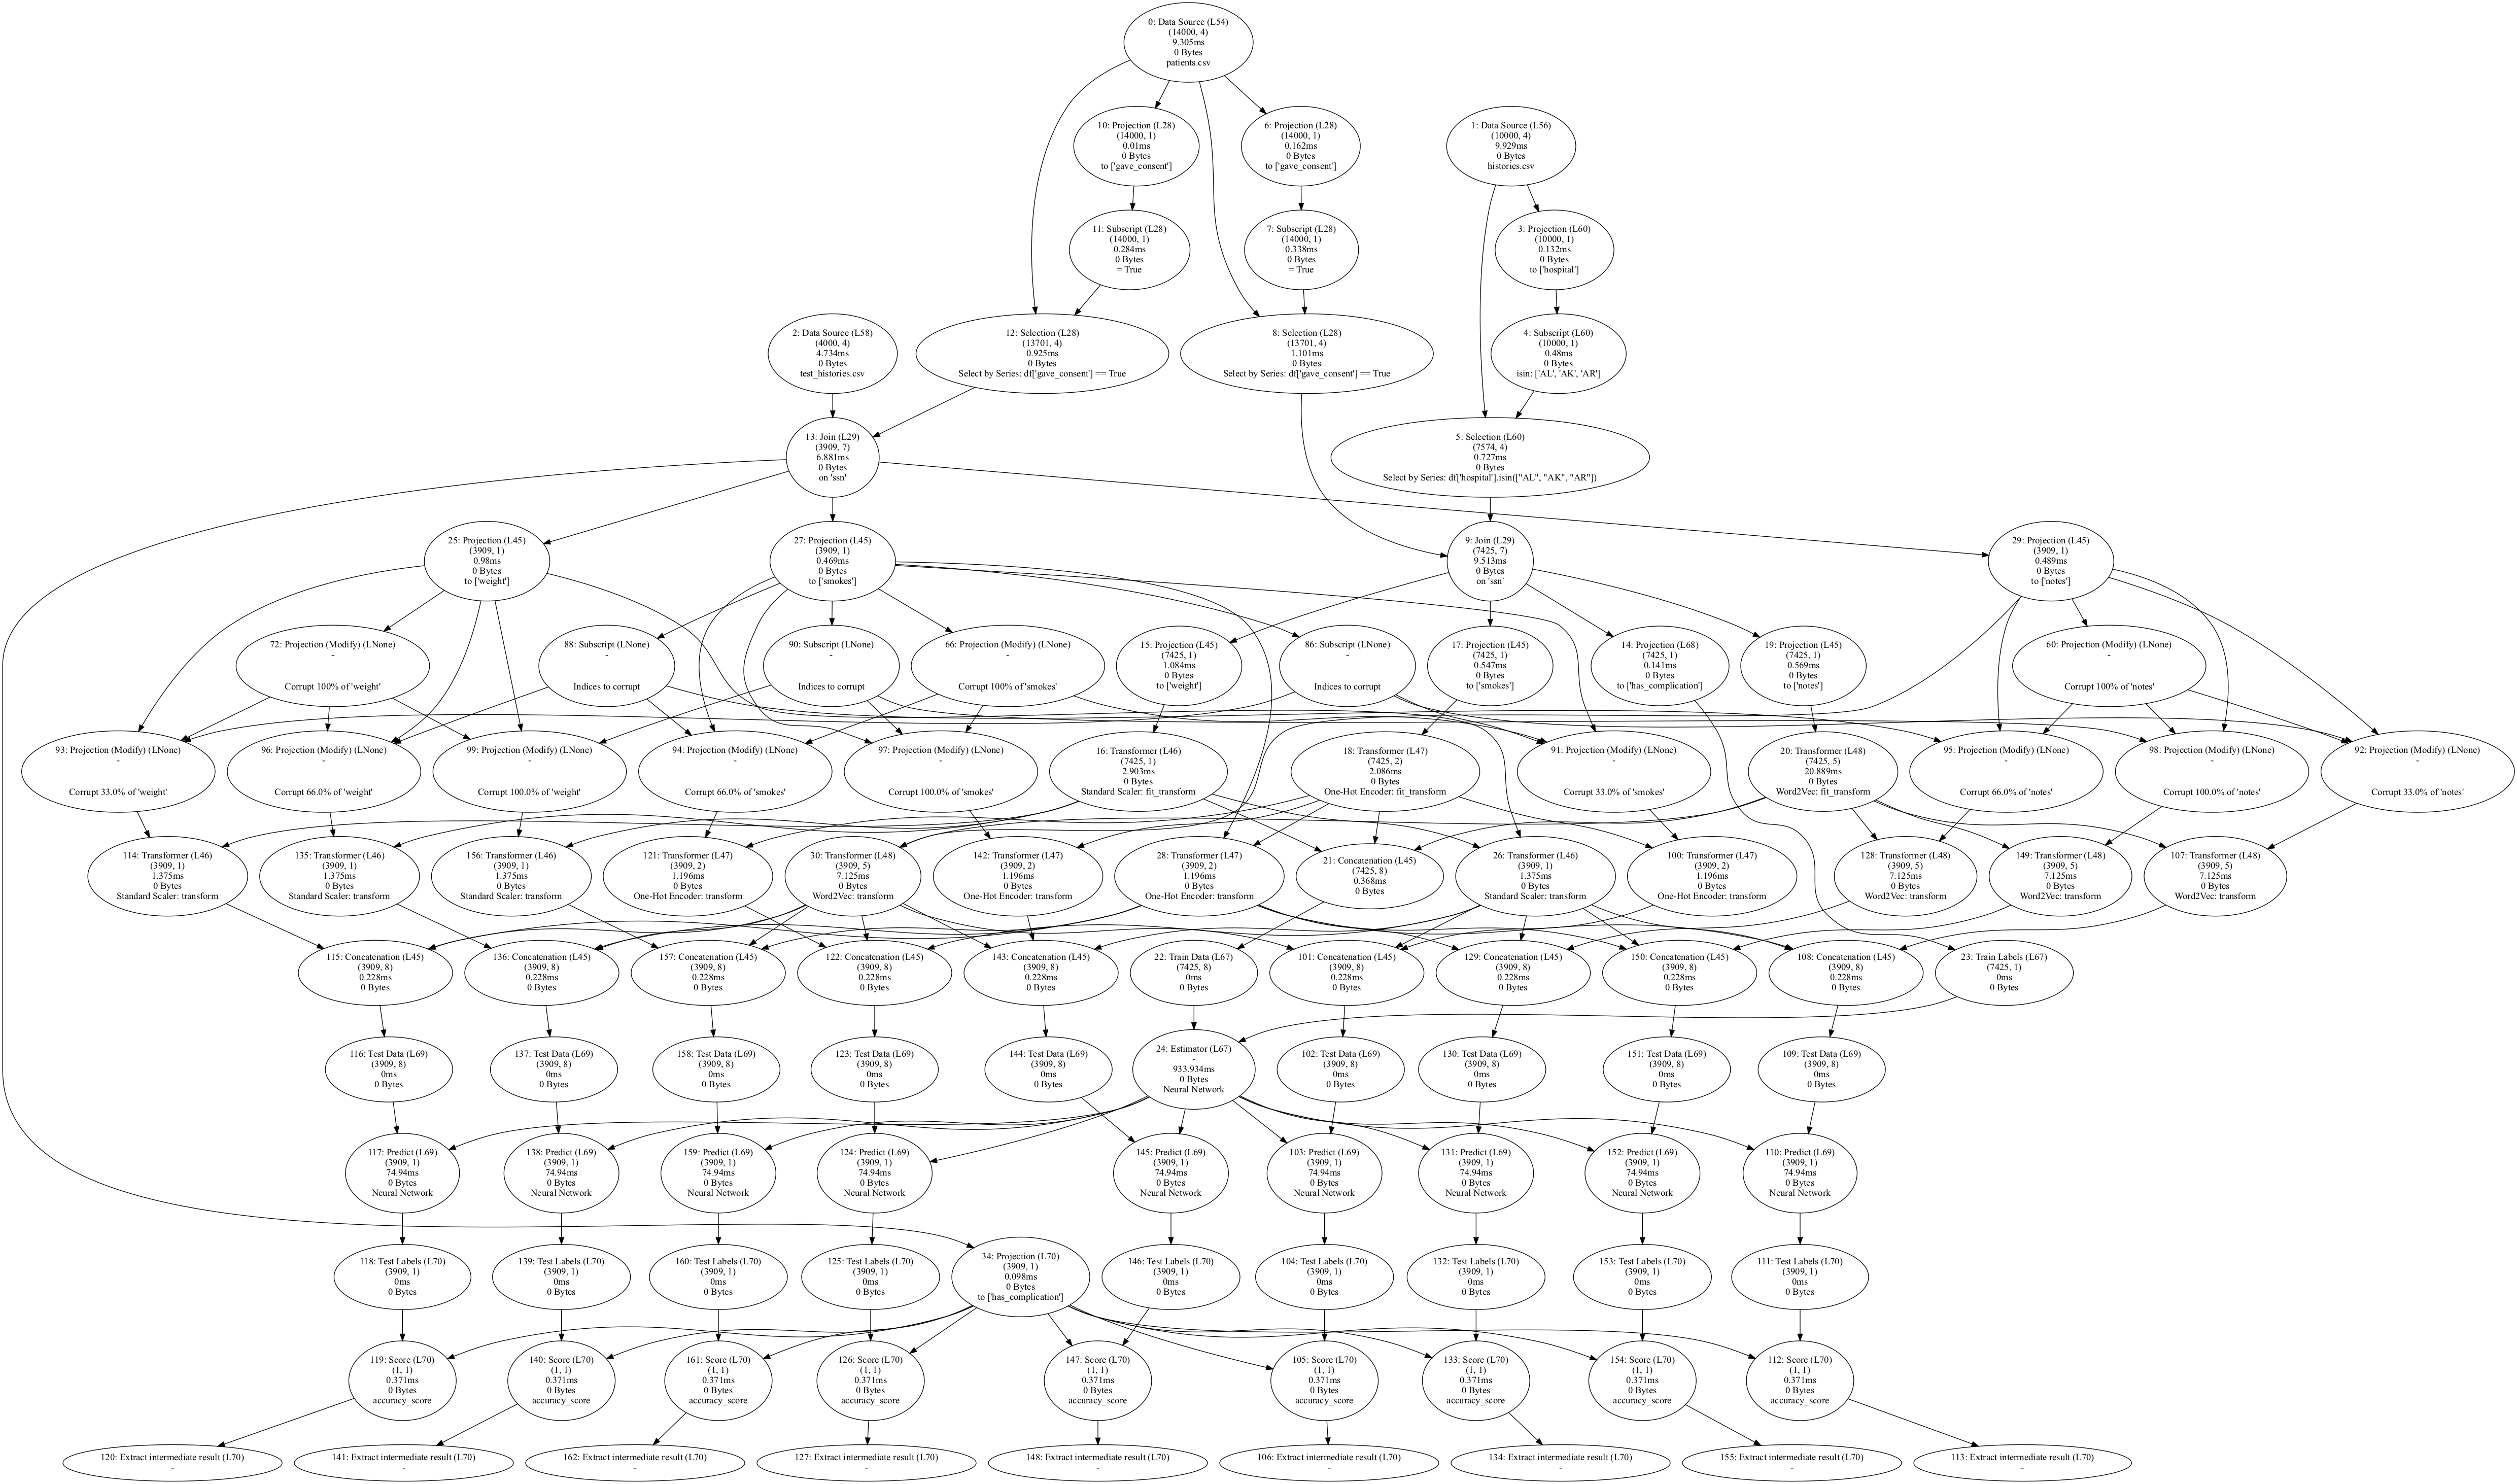

In [7]:
Image(filename=f"{EXAMPLE_OPTIMIZED_PLAN_PATH}.png")

However, these plans can become very complex quickly.

2022-10-14 10:38:17 INFO  Running instrumented original pipeline...
2022-10-14 10:38:17 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 10:38:17 INFO  ---RUNTIME: Importing and monkey-patching took 9.197235107421875 ms
2022-10-14 10:38:18 INFO  ---RUNTIME: Original pipeline execution took 910.6075763702393 ms (excluding imports and monkey-patching)
2022-10-14 10:38:18 INFO  Starting execution of 1 what-if analyses...
2022-10-14 10:38:18 INFO  Start plan generation for analysis DataCorruption...
2022-10-14 10:38:18 INFO  ---RUNTIME: Plan generation took 0.21696090698242188 ms
2022-10-14 10:38:18 INFO  Estimated runtime of original DAG is 871.8400001525879ms
2022-10-14 10:38:18 INFO  Performing Multi-Query Optimization
2022-10-14 10:38:18 INFO  Estimated unoptimized what-if runtime is 7846.560001373291ms
2022-10-14 10:38:18 INFO  Estimated optimised what-if runtime is 1460.3135585784912ms
2022-10-14 10:38:18 INFO  Estim

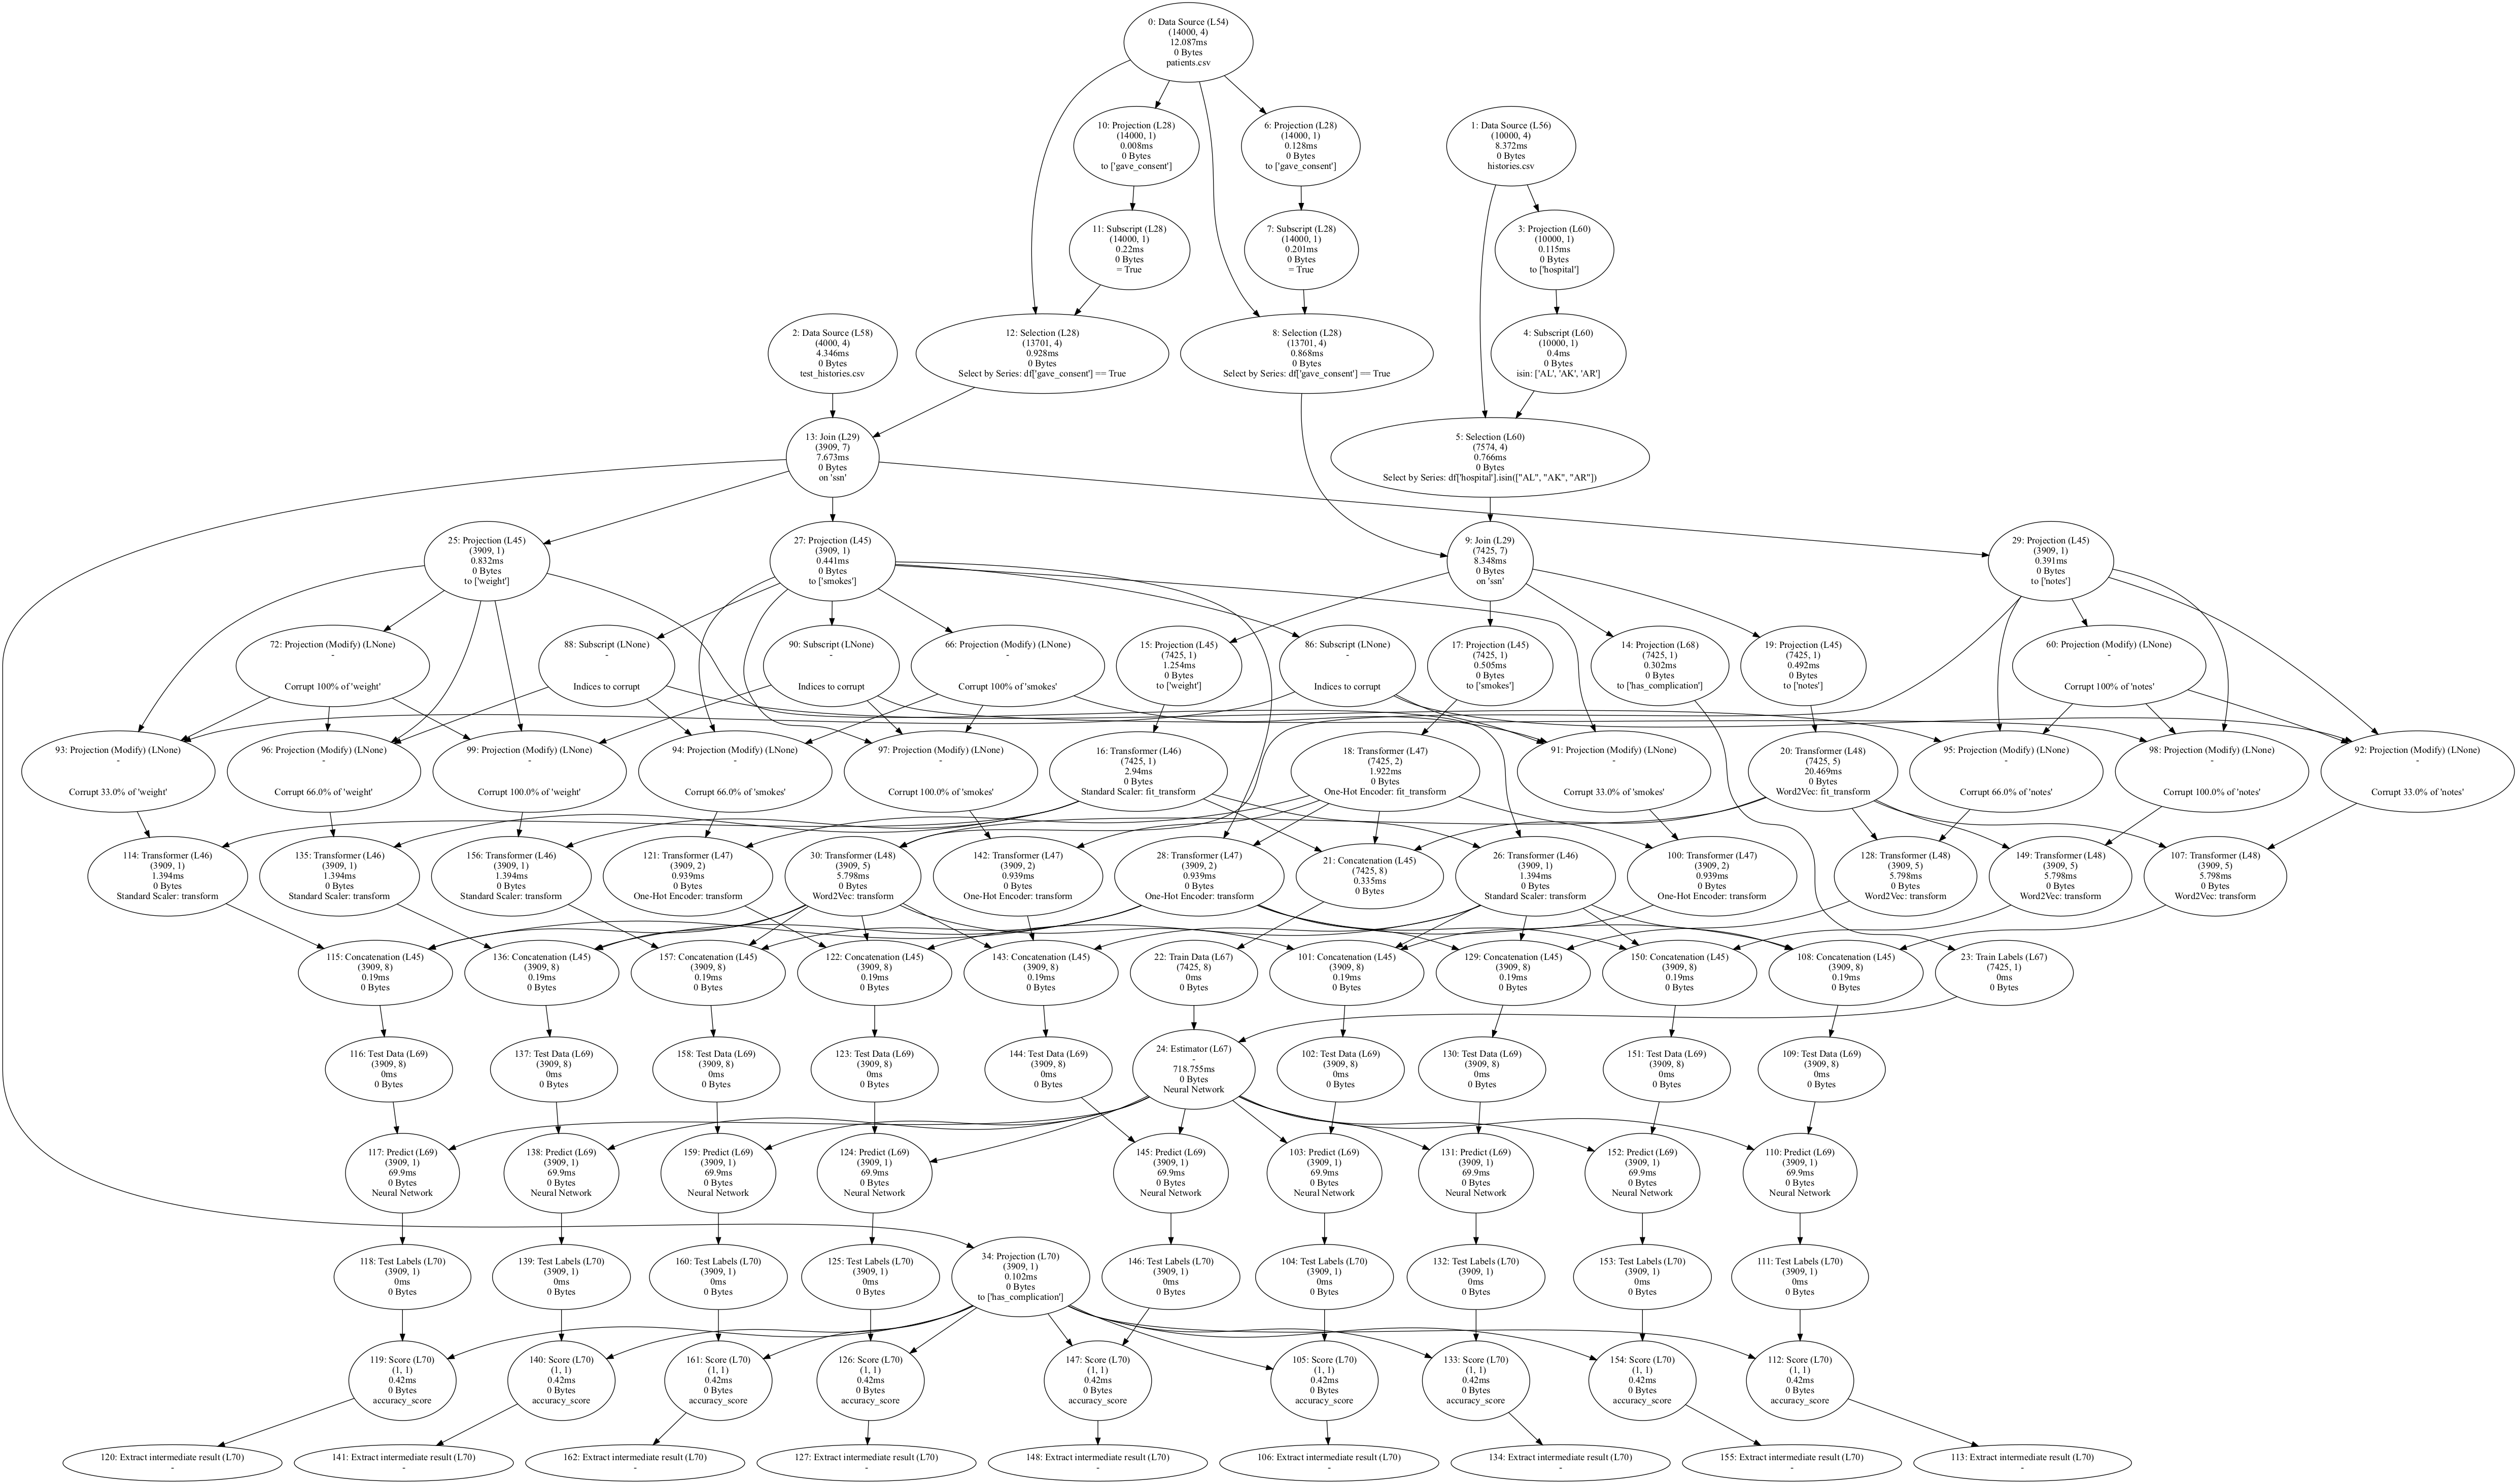

In [8]:
EXAMPLE_COMPLEX_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "example-complex")
PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(robustness) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .estimate() \
    .save_optimised_what_if_dags_to_path(EXAMPLE_COMPLEX_PATH)
# Saving the large plan as image and loading it takes some time
Image(filename=f"{EXAMPLE_COMPLEX_PATH}.png")